In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from transformers import AutoConfig, AutoTokenizer, AutoModel, TFAutoModel, pipeline
import math
from keras import backend as K
from tensorflow.keras.optimizers import Adam

In [162]:
%matplotlib inline

## load Data
First, we need to load our data set from the xlxs file. Simply, by using the panda library we can extract all of the text and data from it.

In [163]:
csvFile = 'HW/Extension1.xlsx'
df = pd.read_excel(csvFile, engine='openpyxl',)
df.head()

,question,answer
0,چگونه می توان از موفقیت آمیز بودن خرید اینترنت...,پس ‎‎‎‎‎‎‎‎‎‎‎‎‎از انجام خرید سیم کارت از طریق...
1,چگونه باید از موفقیت آمیز بودن خرید اینترنتی ه...,پس ‎‎‎‎‎‎‎‎‎‎‎‎‎از انجام خرید سیم کارت از طریق...
2,از چه راهی باید وضعیت خرید اینترنتی را مشاهده ...,پس ‎‎‎‎‎‎‎‎‎‎‎‎‎از انجام خرید سیم کارت از طریق...
3,روشی که می‌توان مطمئن شد خرید اینترنتی به درست...,پس ‎‎‎‎‎‎‎‎‎‎‎‎‎از انجام خرید سیم کارت از طریق...
4,برای این‌که مطمئن بشیم که خرید اینترنتی به درس...,پس ‎‎‎‎‎‎‎‎‎‎‎‎‎از انجام خرید سیم کارت از طریق...


After that, by looking at our answers(labels), we can find out we need to change the form of all of them. easiest way is changing them by a number.



In [164]:
labels = {} 
counter = 0
for count in range(len(df.answer)):
    if df.answer[count] == df.answer[count]:
        if df.answer[count] not in labels.values(): 
            labels[counter] = df.answer[count]
            counter +=1
        df.answer[count] = counter
    



We had some col in our xlx file which had Null value; For training in best form, we need to remove all of them.




In [165]:
df = df.dropna()

/workspace16/Shayan/Shayan-env/lib64/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of ham and spam messages')

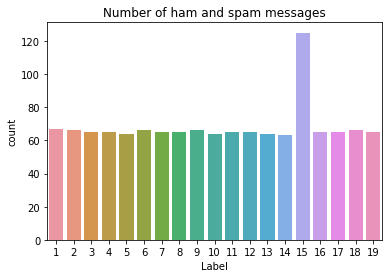

In [166]:
sns.countplot(df.answer)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')



In this part, we split our data set into training and testing part.




In [167]:
X = df.question
Y = df.answer
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)





It is natural to change our labels which are number to binary form with "to_categorical" function




In [168]:
Y_ = to_categorical(Y, num_classes=len(labels))
Y__ = to_categorical(Y_test, num_classes=len(labels))

In [169]:
model_name_or_path = "HooshvareLab/bert-fa-zwnj-base"
config = AutoConfig.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
ParseBERT_model = AutoModel.from_pretrained(model_name_or_path)

Some weights of the model checkpoint at HooshvareLab/bert-fa-zwnj-base were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at HooshvareLab/bert-fa-zwnj-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.poo

    

Our training data set are words which we cannot train our model with, based on that we need to use Tokenizer to create a token for each word and create many vectors as our input for training our model with them.




In [182]:
max_words = 500
max_len = 50
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix_train = sequence.pad_sequences(sequences,maxlen=max_len, dtype='float')

In [171]:
tok.fit_on_texts(X_test)
sequences = tok.texts_to_sequences(X_test)
sequences_matrix_test = sequence.pad_sequences(sequences,maxlen=max_len, dtype='float')

In [172]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + 
    K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [173]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,150,input_length=max_len)(inputs)
    layer = LSTM(32,return_sequences=True)(layer)
    layer = Dropout(0.5)(layer)
    layer = LSTM(32)(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(19,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [174]:
model = RNN()
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy',f1_score_m])

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 50)]              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 50, 150)           75000     
_________________________________________________________________
lstm_14 (LSTM)               (None, 50, 32)            23424     
_________________________________________________________________
dropout_14 (Dropout)         (None, 50, 32)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
_________________________________________________________________
out_layer (Dense)            (None, 19)                627 

In [175]:
model.fit(sequences_matrix_train,Y_,batch_size=8,epochs=20,validation_data=(sequences_matrix_test, Y__))

Epoch 1/20
162/162 [==============================] - 4s 13ms/step - loss: 2.6908 - accuracy: 0.1497 - f1_score_m: 0.0027 - val_loss: 2.2689 - val_accuracy: 0.1885 - val_f1_score_m: 0.0000e+00
Epoch 2/20
162/162 [==============================] - 2s 11ms/step - loss: 1.8967 - accuracy: 0.3673 - f1_score_m: 0.0993 - val_loss: 1.8016 - val_accuracy: 0.4308 - val_f1_score_m: 0.1453
Epoch 3/20
162/162 [==============================] - 2s 11ms/step - loss: 1.3779 - accuracy: 0.5424 - f1_score_m: 0.2705 - val_loss: 1.5311 - val_accuracy: 0.5038 - val_f1_score_m: 0.1861
Epoch 4/20
162/162 [==============================] - 2s 11ms/step - loss: 1.0336 - accuracy: 0.6582 - f1_score_m: 0.4867 - val_loss: 1.4411 - val_accuracy: 0.5500 - val_f1_score_m: 0.4161
Epoch 5/20
162/162 [==============================] - 2s 11ms/step - loss: 0.8352 - accuracy: 0.7230 - f1_score_m: 0.6087 - val_loss: 1.3838 - val_accuracy: 0.5846 - val_f1_score_m: 0.4889
Epoch 6/20
162/162 [==============================]

In [176]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
accr = model.evaluate(test_sequences_matrix,Y__)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

9/9 [==============================] - 0s 4ms/step - loss: 1.8735 - accuracy: 0.6154 - f1_score_m: 0.5947
Test set
  Loss: 1.873
  Accuracy: 0.615


In [222]:
def inference(question):
  sequences = tok.texts_to_sequences(X)
  sequences_matrix_test = sequence.pad_sequences(sequences,maxlen=max_len, dtype='float')

  hold = model.predict(sequences_matrix_test)
  A_ = np.argmax(hold,axis=1)
  
  labels_pred = {} 
  counter = 0
  for count in range(A_.shape[0]):
      if A_[count] == A_[count]:
          if A_[count] not in labels_pred.values(): 
              labels_pred[counter] = A_[count]
              counter +=1
          A_[count] = counter
          
  indx = int(list(labels_pred.keys())[list(labels_pred.values()).index(max(labels_pred.values()))])
  print(indx)
  print(labels[indx])

In [223]:
inference("بسته خوشامد سیمکارت اعتباری عادی شامل چی میشه")

18
بسته خوش آمد سیم کارت اعتباری عادی همراه اول به شرح ذیل می باشد: 1 گیگابایت اینترنت هدیه به مدت 30 روز 24 گیگابایت اینترنت هدیه 6 ماهه (هر ماه 4 گیگابایت به مدت 7 روزه) 100 دقیقه مکالمه درون شبکه (تلفن ثابت و همراه اول) به مدت 30 روز بسته 10000 تومان شارژ هدیه درون شبکه به مدت 90 روز 10000 تومان شارژ هدیه، در صورت افزایش اعتبار ارائه می شود. مهلت زمانی اولین افزایش شارژ، حداکثر 90 روز پس از فعالسازی سیم کارت می باشد.
